# Neural Language Model with FF Neural Network

## Reading corpus and cleaning data

This function reads the main corpus of news

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def read_corpus(path):
  corpus = ''
  count = 0
  with open(path,'r',encoding='utf-8') as file:
    for line in file:

      if count > 500 :
        break
      if line.startswith('.DID') or line.startswith('date') or line.startswith('Cat'):
        if line.startswith('.DID'):
          count += 1
        continue
      corpus += ' ' + line.strip()
  return corpus

This function finds rare words in a text (which can be misspelled words).

In [3]:
def get_rare_words(corpus,N):
  word_count = {}
  rare_words = []
  sentence = corpus.split()
  # print(sentence)
  for word in sentence:
    if word in word_count.keys():
      word_count[word] += 1
    else:
      word_count[word] = 1
  for key, value in word_count.items():
    if value <= N :
      rare_words.append(key)
  return rare_words

In [4]:
corpus = read_corpus("/content/drive/MyDrive/hamshahri.txt")
rare_words = get_rare_words(corpus,1)

Remove punctuation marks, non-aplhabetic tokens, and lowercase tokens

In [5]:
def clean_sentence(sentence):
  words = sentence.split(' ')
  words = [w.replace('\u200c','') for w in words]
  # third parameter says remove these character
  # first parameter says to replace that argument with the argument in second parameter
  translation_table = str.maketrans('','',"\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~،؟!❊#$٪^&*)(ـ+=-؛:{}")
  words = [w.translate(translation_table) for w in words]
  words = [w for w in words if w.isalpha()]
  words = [w for w in words if w not in rare_words]
  return words


In [6]:
import pickle
import regex as re
saved_before = False
data_path = "/content/drive/MyDrive/hamshahri.txt"
if not saved_before:
  corpus = read_corpus(data_path)
  rare_words = get_rare_words(corpus,1)
  sentences = re.split('[.!؟]',corpus)
  token_corpus = [clean_sentence(sentence) for sentence in sentences]
  loc = open("/content/drive/MyDrive/corpus.txt", 'wb')
  pickle.dump(token_corpus,loc)
else:
  loc = open("/content/drive/MyDrive/corpus.txt", 'rb')
  token_corpus = pickle.load(loc)

token_corpus = token_corpus[:-1]
loc.close()


## Neural network

![](https://drive.google.com/uc?export=view&id=1cJvHX2Tq3V4YqtOMOA0OfWVtalYSuOhz)

in this function we create sequences of sentences with length of 4.

In [7]:
def create_sequence(token_corpus):
  nn_input = 3
  seq_length = nn_input + 1
  sequences = []
  for sen in token_corpus:
    if len(sen)>= seq_length:
      for i in range(0,len(sen)):
        if not len(sen) - (i+seq_length)<4:
         sequence = sen[i:i+seq_length]
         line = ' '.join(sequence)
         sequences.append(sequence)
  return sequences

In [8]:
sequences = create_sequence(token_corpus)
print(sequences[78])

['بد', 'میارزه', 'به', 'همهچیو']


In this function we are mapping each word to a number.

In [9]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer and fit it on the input text
tokenizer = Tokenizer()
# make mapping
tokenizer.fit_on_texts(sequences)
# apply mapping
# tokenize the sequences into encoded numbers
sequences = tokenizer.texts_to_sequences(sequences)

In [10]:
print(sequences[78])

[18, 2, 5, 51]


This function shows how many unique words we have.

In [11]:
v_size = len(tokenizer.word_index) + 1
print(v_size)

79


In [12]:
import numpy as np
print(np.shape(sequences))

(247, 4)


We should split sequences to 3 for neural network input and 1 for net output.

In [13]:
sequences = np.array(sequences)
x = sequences[:,:3]
y = sequences[:,-1].reshape(-1,1)

In [14]:
from tensorflow.keras.utils import to_categorical
# convert the output into categorical format required for training the model
y = to_categorical(y, num_classes = v_size)

In [15]:
print(np.shape(y))
print(np.shape(x))

(247, 79)
(247, 3)


Creating train,test and validation sets.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.4,random_state=42)

In [17]:
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test,Y_test,test_size=0.5,random_state=42)

In [18]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))
print(np.shape(X_validation))
print(np.shape(Y_validation))

(148, 3)
(148, 79)
(50, 3)
(50, 79)
(49, 3)
(49, 79)


Using callbacks we can run a special functions in different stage of process.

In [19]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class plot_loss(keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
        self.i = 0
        self.xs = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

  def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.xs.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.xs, self.losses, label="loss")
        plt.plot(self.xs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plots = plot_loss()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten

model = Sequential()
# 50 is length of embedding
# v_size is range of integer numbers we have
model.add(Embedding(v_size,50,input_length = 3 ,name='Embedding-layer'))
model.add(Flatten())
model.add(Dense(int(v_size/2), activation='relu', name='Hidden-layer'))
model.add(Dense(v_size,activation='softmax',name='Output-layer'))

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-layer (Embedding)  (None, 3, 50)            3950      
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 Hidden-layer (Dense)        (None, 39)                5889      
                                                                 
 Output-layer (Dense)        (None, 79)                3160      
                                                                 
Total params: 12,999
Trainable params: 12,999
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
#check point saves the best model in a specific address
checkpoint = ModelCheckpoint('/content/drive/MyDrive/model-{epoch:03d}--{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, 
                             save_weights_only=True, mode='min')  

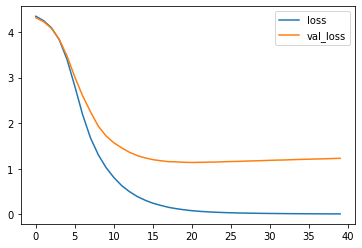


Epoch 40: val_loss did not improve from 1.13798
30/30 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.2287 - val_accuracy: 0.8367


In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=5, epochs=40, validation_data=(X_validation,Y_validation), callbacks=[plots,checkpoint])

## Testing model

In [24]:
best_model_path = '/content/drive/MyDrive/model-018--0.836735.h5'
model.load_weights(best_model_path)

In [25]:
res = model.predict(X_test[0:51])

In [26]:
def convert_ID_to_word(ID):  
  for word, index in tokenizer.word_index.items():
    if np.int64(index) == ID:
      return word
  return

In [27]:
def get_sentence_from_IDs(x):
  sent = ''
  for elem in x:
    sent += convert_ID_to_word(elem) + ' '
  return sent

In [28]:
arr = [0,6, 13, 14, 17, 20, 25]
for i in arr:
  print( get_sentence_from_IDs(X_test[i]) +' : '+ convert_ID_to_word(np.argmax(res[i])))

به صدتا عکس  : تکی
سلفی تار دونفره  : میارزه
اون پرترههای جذابت  : عکس
و متن و  : و
عکس تکی هنری  : کنار
شرایط بد میارزه  : به
میگم میدونی قشنگترین  : عکسی
